In [1]:
import os
import glob
import itertools
import json
import importlib

import pingouin as pg
import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl

In [2]:
import analyze2p.utils as hutils
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.plotting as pplot
import analyze2p.extraction.rois as rutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.objects.selectivity as sel

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Aggregate

In [6]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)

In [7]:
sdata, cells0, missing_ = aggr.get_aggregate_info(visual_areas=visual_areas, 
                                                  create_new=False,
                                                  return_cells=True, return_missing=True)
all_cell_counts = cells0[['visual_area', 'datakey', 'cell']]\
                    .drop_duplicates().groupby(['visual_area']).count().reset_index()

print(all_cell_counts.groupby(['visual_area']).sum())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
             datakey  cell
visual_area               
Li              3661  3661
Lm              4144  4144
V1              4028  4028


In [9]:
experiment='blobs'
trial_epoch = 'stimulus'
responsive_test='ROC'
# ---------------------------------------
responsive_thr=0.05 if responsive_test=='ROC' else 10.
response_type='dff'
traceid = 'traces001'

assigned_cells, meta = aggr.select_assigned_cells(cells0, sdata, 
                                        experiments=[experiment])
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                                       response_type=response_type,
                                       trial_epoch=trial_epoch,
                                       responsive_test=responsive_test,
                                       responsive_thr=responsive_thr)
# Get unique dkeys and count
n_responsive, blobs_dkeys = aggr.count_n_responsive(NDATA0, u_dkeys=None)
n_total = aggr.count_n_total(assigned_cells, blobs_dkeys)
u_dkeys = blobs_dkeys

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
...loading: aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
    renaming: 20190306_JC061_fov3
    renaming: 20190319_JC067_fov1
    renaming: 20190320_JC067_fov1
    renaming: 20190314_JC070_fov1
    renaming: 20190315_JC070_fov1
    renaming: 20190316_JC070_fov1
    renaming: 20190321_JC070_fov1
    renaming: 20190322_JC073_fov1
    renaming: 20190327_JC073_fov1
Checking mislabeled
20190306_JC061_fov3: renamed configs
20190319_JC067_fov1: renamed configs
20190320_JC067_fov1: renamed configs
20190314_JC070_fov1: renamed configs
20190315_JC070_fov1: renamed configs
20190316_JC070_fov1: renamed configs
20190321_JC070_fov1: renamed configs
20190322_JC073_fov1: renamed configs
20190327_JC073_fov1: renamed configs
[V1] Animalid does not exist: JC078 


In [12]:
SDF, mislabeled = aggr.check_sdfs(meta['datakey'].unique(), experiment=experiment,
                     images_only=False, rename=True, return_incorrect=True,
                     return_all=True)

    renaming: 20190314_JC070_fov1
    renaming: 20190315_JC070_fov1
    renaming: 20190316_JC070_fov1
    renaming: 20190319_JC067_fov1
    renaming: 20190320_JC067_fov1
    renaming: 20190321_JC070_fov1
    renaming: 20190322_JC073_fov1
    renaming: 20190327_JC073_fov1
    renaming: 20190306_JC061_fov3


In [44]:
min_ncells=5
NDATA = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys and len(g['cell'].unique())>=min_ncells])


In [45]:
'20190426_JC078' in NDATA['datakey'].unique()

False

In [46]:
cnts = aggr.count_n_cells(NDATA, name='n_cells')

In [47]:
for va, g in cnts.groupby('visual_area'):
    dk_ix = [int(i) for i in np.arange(0, len(g['datakey']))]
    cnts.loc[g.index, 'site_num'] = dk_ix
cnts.dtypes

visual_area     object
datakey         object
n_cells          int64
site_num       float64
dtype: object

<IPython.core.display.Javascript object>


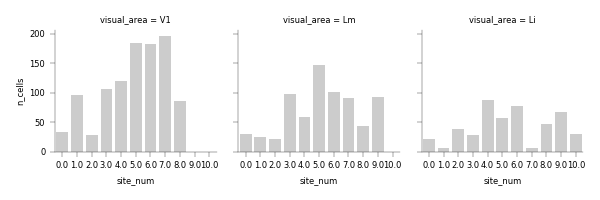

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


,datakey,n_cells,site_num
visual_area,,,
Li,20190315_JC070_fov1,7,0.0
Lm,20190306_JC061_fov3,22,0.0
V1,20190501_JC076_fov1,28,0.0


In [49]:
%matplotlib notebook
fg = sns.FacetGrid(col='visual_area', data=cnts, height=2, col_order=visual_areas)
fg.map(sns.barplot, 'site_num', 'n_cells', color=[0.8]*3)
cnts.groupby('visual_area').min()

In [50]:
cnts[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

Li    11
Lm    10
V1     9
Name: visual_area, dtype: int64

# Calculate lifetime sparseness 

In [172]:
def calculate_metrics(x0, sdf, iternum=None):

    rdf = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
    rdf['size'] = [sdf['size'][c] for c in rdf['config']]
    rdf['morphlevel'] = [sdf['morphlevel'][c] for c in rdf['config']]
    # Calculate morph selectivity (@ best size)
    morph_ixs = rdf[rdf['morphlevel']!=-1].groupby(['cell'])\
                    .apply(sel.assign_morph_ix, at_best_other=True)\
                    .rename(columns={0:'morph_sel'})
    # Calculate size tolerance (@ best morph)
    size_tols = rdf[rdf['morphlevel']!=-1].groupby(['cell'])\
                    .apply(sel.assign_size_tolerance, at_best_other=True)\
                    .rename(columns={0:'size_tol'})
    # calculate sparseness, all morph images
    sparse_morphs = rdf[rdf['morphlevel']!=-1][['cell', 'response']]\
                    .groupby(['cell']).apply(sel.assign_sparseness)\
                    .rename(columns={0:'sparseness_morphs'})
    # calculate sparseness on anchors only 
    sparse_anchors = rdf[rdf['morphlevel'].isin([0, 106])][['cell', 'response']]\
                    .groupby(['cell']).apply(sel.assign_sparseness)\
                    .rename(columns={0:'sparseness_anchors'})
    # calculate sparseness on anchors only 
    sparse_all = rdf[['cell', 'response']]\
                    .groupby(['cell']).apply(sel.assign_sparseness)\
                    .rename(columns={0:'sparseness_total'})
    # Calculate how selective to SIZE (@ best morph)
    size_sel = rdf[rdf['morphlevel']!=-1].groupby(['cell'])\
                    .apply(sel.assign_lum_ix, at_best_other=True)\
                    .rename(columns={0:'size_sel'})
    if -1 in rdf['morphlevel'].unique():
        # How selective is each cell to the LUMINANCE levels
        lum_sel = rdf[rdf['morphlevel']==-1].groupby(['cell'])\
                        .apply(sel.assign_lum_ix, at_best_other=True)\
                        .rename(columns={0:'lum_sel'})
        # Luminance corrs: corr coef. bw size-tuning at best morph 
        # vs "size"-tuning at lum control (no morph)
        lum_ccs = rdf.groupby(['cell']).apply(sel.get_lum_corr)
        #lum_ccs.index = lum_ccs.index.droplevel()
    else:
        lum_sel = pd.DataFrame({'lum_sel': [None]*len(morph_ixs)},
                                 index=morph_ixs.index)
        lum_ccs = pd.DataFrame({'lum_size_cc': [None]*len(morph_ixs),
                                'lum_size_pval': [None]*len(morph_ixs)}, 
                                 index=morph_ixs.index)
    # Combine 
    ixs_ = pd.concat([morph_ixs, size_tols, sparse_all, sparse_morphs, sparse_anchors,
                      size_sel, lum_sel, lum_ccs], axis=1)
    ixs_['cell'] = ixs_.index
    if iternum is not None:
        ixs_['iteration'] = iternum
    return ixs_

In [129]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [104]:
cnts[cnts.visual_area=='Li']

,visual_area,datakey,n_cells,site_num
0,Li,20190315_JC070_fov1,22,0.0
1,Li,20190316_JC070_fov1,7,1.0
2,Li,20190322_JC073_fov1,38,2.0
3,Li,20190422_JC076_fov1,29,3.0
4,Li,20190602_JC091_fov1,87,4.0
5,Li,20190609_JC099_fov1,57,5.0
6,Li,20190614_JC091_fov1,78,6.0
7,Li,20190617_JC099_fov1,7,7.0
8,Li,20191018_JC113_fov1,47,8.0
9,Li,20191105_JC117_fov1,67,9.0


In [327]:
va='V1'
dk = '20191006_JC110_fov1'

va='Li'
dk = '20191105_JC117_fov1'

x0=NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
sdf = SDF[SDF.datakey==dk]

<IPython.core.display.Javascript object>


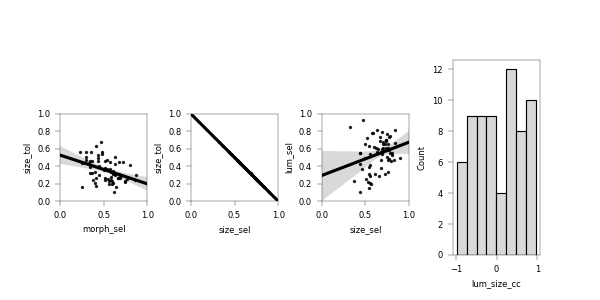

In [331]:
fig, axn = pl.subplots(1,4, figsize=(6,3))
for ax in axn[0:-1]:
    ax.set_aspect('equal')
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
    
ax=axn[0]
sns.regplot(x='morph_sel', y='size_tol', data=ixs_, ax=ax, 
            truncate=False, color='k', scatter_kws={'s':2})
ax=axn[1]
sns.regplot(x='size_sel', y='size_tol', data=ixs_, ax=ax, 
            truncate=False, color='k', scatter_kws={'s':2})
ax=axn[2]
sns.regplot(x='size_sel', y='lum_sel', data=ixs_, ax=ax,
            truncate=False, color='k', scatter_kws={'s':2})
ax=axn[3]
sns.histplot(x='lum_size_cc', data=ixs_, ax=ax,
            color=[0.8]*3)

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.8, wspace=0.5)

## Aggregate metrics

In [173]:
exclude=[] # wrong configs
images='all'
remove_offset=False # Set false, offsets removed if neg. in calculatin index
d_=[]
for (va, dk), x0 in NDATA.groupby(['visual_area', 'datakey']):
    if dk in exclude:
        continue
    if dk not in SDF['datakey'].values:
        continue
    sdf = aggr.get_stimuli(dk, experiment=experiment, match_names=True)
    configs = sdf.index.tolist()
    if remove_offset:
        x0['response'] = x0['response'] - x0.groupby(['cell'])['response'].transform('min')
    tmpdf = calculate_metrics(x0[x0.config.isin(configs)], sdf)
    tmpdf['visual_area'] = va
    tmpdf['datakey'] = dk
    tmpdf['n_cells'] = len(x0['cell'].unique())
    d_.append(tmpdf.reset_index(drop=True))

ixdf = pd.concat(d_, axis=0, ignore_index=True)

In [162]:
ixdf= pd.concat(d_, axis=0, ignore_index=True)

In [185]:
ixdf['lum_sel'] = ixdf['lum_sel'].astype(float) #.dtypes
ixdf['lum_size_cc'] = ixdf['lum_size_cc'].astype(float) #.dtypes
ixdf['lum_size_pval'] = ixdf['lum_size_pval'].astype(float) #.dtypes

In [174]:
ixdf['n_cells'].min()

7

In [587]:
min_ncells=10
# xdf = ixdf[(ixdf['sparseness_morphs']<=1) & (ixdf['sparseness_morphs']>=0)
#           & (ixdf['n_cells']>=min_ncells)].copy()
# print(ixdf.shape, xdf.shape)
xdf = ixdf[(ixdf['size_sel']<=1) & (ixdf['size_sel']>=0)
          & (ixdf['morph_sel']<=1) & (ixdf['morph_sel']>=0)
          & (ixdf['lum_sel']<=1) & (ixdf['lum_sel']>=0)
          & (ixdf['sparseness_morphs']<=1) & (ixdf['sparseness_morphs']>=0)].copy()
print(ixdf.shape, ixdf.dropna().shape, xdf.shape)

min_ncells=10
DF = xdf[xdf['n_cells']>=min_ncells].copy()

(2213, 13) (2091, 13) (2091, 13)


In [670]:
means_by_fov = DF.groupby(['visual_area', 'datakey']).median().reset_index()
ncells_by_fov = DF.groupby(['visual_area', 'datakey']).count().reset_index()[['visual_area', 'datakey', 'cell']]\
                    .rename(columns={'cell': 'n_cells'})
fovdf = pd.merge(means_by_fov, ncells_by_fov, on=['visual_area', 'datakey'])

# Output plotting

In [588]:
aggregate_dir= '/n/coxfs01/julianarhee/aggregate-visual-areas'
FIGDIR = os.path.join(aggregate_dir, 'FIGURES')
bw_area_colors={'V1': [0.7]*3, 'Lm': [0.7]*3, 'Li': [0.7]*3}
fontsize=6
lw=0.25

dst_dir = os.path.join(aggregate_dir, 'blobs-tuning', \
                       'selectivity_tolerance', 'final')
print(dst_dir)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

data_id = '%s|%s_%s-%.2f' % (traceid, response_type, responsive_test, responsive_thr)
data_id

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final


'traces001|dff_ROC-0.05'

<IPython.core.display.Javascript object>


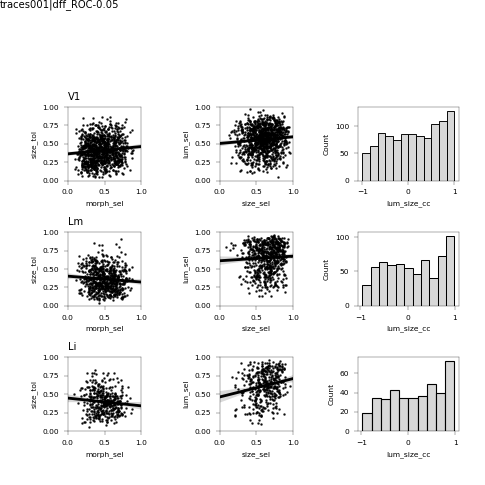

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final morph_sel_size_tol_alldata


In [589]:
fig, axn = pl.subplots(3,3, figsize=(6,6))
for ax in axn[:, 0:-1].flat:
    ax.set_aspect('equal')
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
    
for va, ixs_ in DF.groupby('visual_area'):
    vi = visual_areas.index(va)
    ax=axn[vi, 0]
    ax.set_title(va, loc='left')
    sns.regplot(x='morph_sel', y='size_tol', data=ixs_, ax=ax, 
                truncate=False, color='k', scatter_kws={'s':1})
    ax=axn[vi, 1]
    sns.regplot(x='size_sel', y='lum_sel', data=ixs_, ax=ax,
                truncate=False, color='k', scatter_kws={'s':1})
    ax=axn[vi, 2]
    sns.histplot(x='lum_size_cc', data=ixs_, ax=ax,
                color=[0.8]*3)

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.5,
                  hspace=0.7)

pplot.label_figure(fig, data_id)

figname = 'morph_sel_size_tol_alldata' 
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

[mean]:
  visual_area  size_tol  morph_sel   lum_sel  size_tol_std  morph_sel_std  \
0          Li  0.395341   0.488739  0.613643      0.156216       0.148236   
1          Lm  0.363296   0.493852  0.651903      0.155331       0.160359   
2          V1  0.408746   0.450344  0.558446      0.164838       0.168344   

   lum_sel_std  
0     0.197555  
1     0.192904  
2     0.171185  


<IPython.core.display.Javascript object>


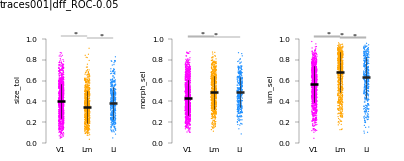

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final sel_tol_index_all_byCELL


In [683]:
%matplotlib notebook
plot_cells=True
multi_comp_test='fdr_bh' #'fdr_bh'
bw = True

curr_colors = bw_area_colors if bw else area_colors
plot_params=['size_tol', 'morph_sel', 'lum_sel']
plot_str = 'byCELL' if plot_cells else 'byFOV'
markersize = 1 if plot_cells else 3
plotdf = DF.dropna().copy() if plot_cells else fovdf.copy()
# ----------------------------------------------------------
pplot.print_means(plotdf, groupby=['visual_area'], params=plot_params)

fig, axn = pl.subplots(1, len(plot_params), figsize=(5, 2), sharex=True, sharey=False)
# y_loc=1
# offset=0.02
ylim=(0,1.04)
for ai, metric in enumerate(plot_params):
    ax=axn[ai]
    sel.stripplot_metric_by_area(plotdf, metric, area_colors=area_colors,
                                markersize=markersize, ylim=ylim, ax=ax,
                                sig_fontsize=4, jitter=plot_cells, 
                                plot_means=plot_cells)
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.85, top=0.8, wspace=0.5)
for ax in axn.flat:
    ax.set_xlabel('')    
    ax.tick_params(which='both', axis='x', size=0)
sns.despine(offset=8, trim=True, bottom=True)

pplot.label_figure(fig, data_id)
figname = 'sel_tol_index_all_%s' % plot_str
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

## By fov metrics

In [644]:
r_=[]
for (va, dk), df_ in DF.groupby(['visual_area', 'datakey']):
    p_r, p_p = spstats.pearsonr(df_['morph_sel'], df_['size_tol'])
    res = pd.Series({'pearson_r': p_r, 'pearson_p': p_p,
               'visual_area': va, 'datkey': dk, 'n_cells': len(df_)})
    r_.append(res)

In [660]:
tradeoff = pd.concat(r_, axis=1, ignore_index=True).T
tradeoff['pearson_r'] = tradeoff['pearson_r'].astype(float)
tradeoff['pearson_p'] = tradeoff['pearson_p'].astype(float)


<IPython.core.display.Javascript object>


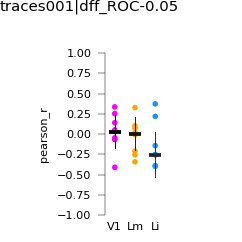

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final tradeoff_pearsonr


In [669]:

fig, stdf = sel.stripplot_metric_by_area(tradeoff, metric='pearson_r', markersize=3, 
                            area_colors=area_colors, posthoc='fdr_by', 
                             ylim=(-1, 1), jitter=False, return_stats=True)
pplot.label_figure(fig, data_id)

figname = 'tradeoff_pearsonr' 
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


<IPython.core.display.Javascript object>


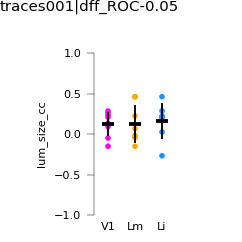

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final lum_size_cc_byFOV


In [740]:
fig, ax= pl.subplots(figsize=(2,2), dpi=150)
sns.stripplot(x='visual_area', y='lum_size_cc', data=fovdf,ax=ax,
             palette=area_colors, order=visual_areas, linewidth=0,
             jitter=False, zorder=-1000, size=3)
sns.pointplot(x='visual_area', y='lum_size_cc', data=fovdf,ax=ax,
          order=visual_areas, ecolor='w', zorder=11000,
          ci='sd', color='k', join=False, markers='_', errwidth=1)
pl.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=.8)
ax.set_box_aspect(2)
ax.set_ylim([-1, 1])
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
sns.despine(bottom=True, trim=True)

pplot.label_figure(fig, data_id)

figname = 'lum_size_cc_byFOV'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

# FOV means

In [680]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

[mean]:
  visual_area  size_tol  morph_sel   lum_sel  size_tol_std  morph_sel_std  \
0          Li  0.389521   0.490815  0.602080      0.053822       0.055099   
1          Lm  0.351221   0.484136  0.654995      0.050210       0.048106   
2          V1  0.394626   0.442141  0.566237      0.024709       0.049751   

   lum_sel_std  
0     0.105119  
1     0.110385  
2     0.038483  


<IPython.core.display.Javascript object>


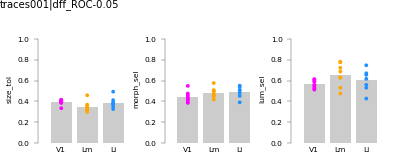

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final sel_tol_index_byFOV


In [701]:
%matplotlib notebook
plot_cells=False
multi_comp_test='fdr_by' #'fdr_bh'
bw = True

curr_colors = bw_area_colors if bw else area_colors
plot_params=['size_tol', 'morph_sel', 'lum_sel']
plot_str = 'byCELL' if plot_cells else 'byFOV'
markersize = 1 if plot_cells else 3
plotdf = DF.dropna().copy() if plot_cells else fovdf.copy()
# ----------------------------------------------------------
pplot.print_means(plotdf, groupby=['visual_area'], params=plot_params)

fig, axn = pl.subplots(1, len(plot_params), figsize=(5, 2), sharex=True, sharey=False)
ylim=(0,1.04)
s_=[]
for ai, metric in enumerate(plot_params):
    ax=axn[ai]
    sns.barplot(x='visual_area', y=metric, data=plotdf, ax=ax,
               order=visual_areas, color=[0.8]*3, ecolor='w', ci=None,
               zorder=-1000)
    sns.stripplot(x='visual_area', y=metric, data=plotdf, ax=ax,
                 order=visual_areas, hue='visual_area', palette=area_colors,
                 size=3, zorder=10000, jitter=False)
    sts = pg.pairwise_ttests(data=plotdf, dv=metric, between='visual_area',
                        parametric=False, padjust=multi_comp_test, effsize='eta-square')
    pplot.annotate_multicomp_by_area(ax, sts, y_loc=1.01, offset=0.01,
                        fontsize=4, lw=0.25)
    sts['metric'] = metric
    s_.append(sts)
    ax.legend_.remove()
    ax.set_ylim(ylim)
statsdf = pd.concat(s_, axis=0, ignore_index=True)
statsdf
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.85, top=0.8, wspace=0.5)
for ax in axn.flat:
    ax.set_xlabel('')    
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_aspect(4)

sns.despine(offset=8, trim=True, bottom=True)

pplot.label_figure(fig, data_id)
figname = 'sel_tol_index_%s' % plot_str
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

[mean]:
  visual_area  size_tol  morph_sel  sparseness_morphs   lum_sel  size_tol_std  \
0          Li  0.395341   0.488739           0.195468  0.613643      0.156216   
1          Lm  0.363296   0.493852           0.222537  0.651903      0.155331   
2          V1  0.408746   0.450344           0.223986  0.558446      0.164838   

   morph_sel_std  sparseness_morphs_std  lum_sel_std  
0       0.148236               0.069464     0.197555  
1       0.160359               0.084730     0.192904  
2       0.168344               0.089867     0.171185  


<IPython.core.display.Javascript object>


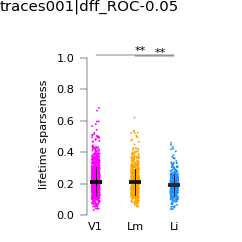

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final lifetimesparseness_byCELL
/n/coxfs01/julianarhee/aggregate-visual-areas/FIGURES lifetimesparseness_byCELL


In [598]:
%matplotlib notebook
metric='sparseness_morphs'
plot_cells=True
multi_comp_test='fdr_bh' #'fdr_bh'

plot_str = 'byCELL' if plot_cells else 'byFOV'
plotdf = DF.dropna().copy() if plot_cells else fovdf.copy()
pplot.print_means(plotdf, groupby=['visual_area'], params=plot_params)
markersize=1 if plot_cells else 2

fig = sel.stripplot_metric_by_area(plotdf, metric, area_colors=area_colors,
                                  markersize=markersize, posthoc=multi_comp_test)
pplot.label_figure(fig, data_id)
fig.axes[0].set_ylabel('lifetime sparseness')


figname = 'lifetimesparseness_%s' % plot_str
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)
print(FIGDIR, figname)

## Population sparseness

In [599]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [600]:
va='V1'
dk='20191006_JC110_fov1'
x0 = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)]

In [601]:
rdf = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
rdf = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
sdf = aggr.get_stimuli(dk, experiment, match_names=True)
rdf['size'] = [sdf['size'][c] for c in rdf['config']]
rdf['morphlevel'] = [sdf['morphlevel'][c] for c in rdf['config']]
remove_offset=True
if remove_offset:
    for ci, x0 in rdf.groupby('cell'):
        if x0['response'].min()<0:
            #print(ci, x0['response'].min())
            offset_c = x0['response'].copy()
            offset_c[x0['response']<0]= 0
            rdf.loc[x0.index, 'response'] = offset_c
psparse3 = rdf.groupby('config').apply(sel.assign_sparseness, name='config')\
                .rename(columns={0:'pop-sparseness'})

<IPython.core.display.Javascript object>


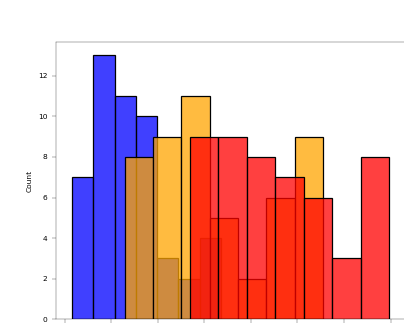

<AxesSubplot:xlabel='pop-sparseness', ylabel='Count'>

In [602]:
fig, ax = pl.subplots()
sns.histplot(psparse['pop-sparseness'], color='b')
sns.histplot(psparse2['pop-sparseness'], color='orange')
sns.histplot(psparse3['pop-sparseness'], color='red')

In [603]:
#x0 = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
remove_offset=False
p_=[]
for (va, dk), x0 in NDATA.groupby(['visual_area', 'datakey']):
    # x0['response'] = x0['response'].abs()
    rdf = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
    rdf = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
    sdf = aggr.get_stimuli(dk, experiment, match_names=True)
    rdf['size'] = [sdf['size'][c] for c in rdf['config']]
    rdf['morphlevel'] = [sdf['morphlevel'][c] for c in rdf['config']]
    if remove_offset:
        for ci, x0 in rdf.groupby('cell'):
            if x0['response'].min()<0:
                #print(ci, x0['response'].min())
                offset_c = x0['response'] - x0['response'].min()
                rdf.loc[x0.index, 'response'] = offset_c
    psparse = rdf.groupby('config').apply(sel.assign_sparseness, name='config')\
                    .rename(columns={0:'pop-sparseness'})
    psparse['visual_area'] = va
    psparse['datakey'] = dk
    psparse['n_cells'] = len(rdf['cell'].unique())
    psparse['config'] = psparse.index.tolist()
    p_.append(psparse.reset_index(drop=True))

pop_sparse = pd.concat(p_, axis=0, ignore_index=True)
popdf = pop_sparse[(pop_sparse['pop-sparseness']<=1.0) 
                 & (pop_sparse['pop-sparseness']>=0)].copy()
print(pop_sparse.shape, popdf.shape)

(1475, 5) (1475, 5)


In [604]:
popdf_fov = popdf.groupby(['visual_area', 'datakey']).mean().reset_index()

In [605]:
pop_by_config = popdf.groupby(['visual_area', 'config']).mean().reset_index()

[mean]:
  visual_area  pop-sparseness  pop-sparseness_std
0          Li        0.333476            0.078205
1          Lm        0.306937            0.094426
2          V1        0.296523            0.087024


<IPython.core.display.Javascript object>


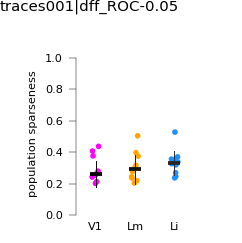

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final populationsparseness_byFOV


In [606]:
%matplotlib notebook
multi_comp_test='fdr_bh' #'fdr_bh'
plot_cells=False

plot_params=['pop-sparseness'] #, 'lum_ix']
markersize = 1 if plot_cells else 3
plot_str = 'byCFG' if plot_cells else 'byFOV'

plotdf = pop_by_config.dropna().copy() if plot_cells else popdf_fov.copy()
pplot.print_means(plotdf, groupby=['visual_area'], params=plot_params)

fig = sel.stripplot_metric_by_area(plotdf, metric='pop-sparseness',
                                  area_colors=area_colors, markersize=markersize)
pplot.label_figure(fig, data_id)
fig.axes[0].set_ylabel('population sparseness')
figname = 'populationsparseness_%s' % (plot_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

print(dst_dir, figname)


<IPython.core.display.Javascript object>


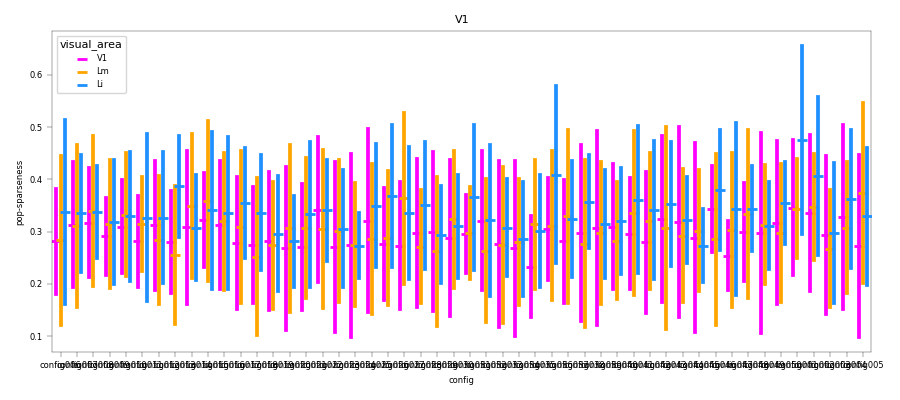

Text(0.5, 1.0, 'V1')

In [471]:
fig, ax = pl.subplots(1, 1, figsize=(9,4), tight_layout=True)

#sns.stripplot(x='config', y='sparseness', data=df_, ax=ax)
sns.pointplot(x='config', y='pop-sparseness', hue='visual_area', data=plotdf, ax=ax,
             join=False, palette=area_colors, markers='_', ci='sd', dodge=0.5,
             hue_order=visual_areas)
ax.set_title(va)

In [212]:
morphlevels = sorted(sdf['morphlevel'].unique())
sizes = sorted(sdf['size'].unique())
n_morphs = len(morphlevels)
n_sizes = len(sizes)

va='V1'
dk='20191006_JC110_fov1'
df_= plotdf[(plotdf.visual_area==va) & (plotdf.datakey==dk)].copy()
cfg_list = sorted(df_.groupby('config')['pop-sparseness'].mean().index.tolist())
morph_arr = sdf.loc[cfg_list]['morphlevel'].values
morph_mat = np.reshape(morph_arr, (n_morphs, n_sizes)).T.astype(float)

size_arr = sdf.loc[cfg_list]['size'].values
size_mat = np.reshape(size_arr, (n_morphs, n_sizes)).T.astype(float)


In [213]:
mat_labels = np.asarray(['(%i, %i)' % (sz, mp) for sz, mp \
                         in sdf[['size', 'morphlevel']].values])\
                        .reshape(n_morphs, n_sizes).T

0.028456460327536622 0.8874716770509359


<IPython.core.display.Javascript object>


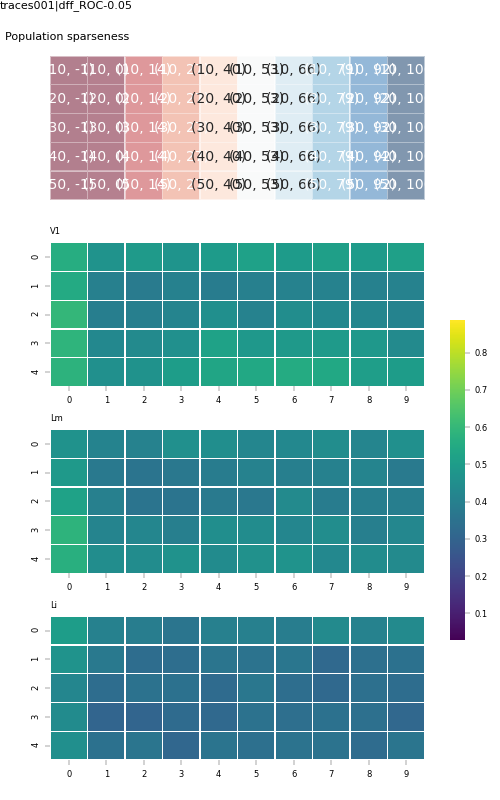

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


Text(0.01, 0.95, 'Population sparseness')

In [214]:
vmin=plotdf['pop-sparseness'].min()
vmax=plotdf['pop-sparseness'].max()
print(vmin, vmax)
cmap='viridis'

# fig = pl.figure(constrained_layout=True, figsize=(5,8))
# gs1 = fig.add_gridspec(nrows=4, ncols=2, left=0.05, right=0.48,
#                         wspace=0.05)
# ax0 = fig.add_subplot(gs1[0, 0:2])
lw=0.1

fig, axn = pl.subplots(4, 1, constrained_layout=True, figsize=(5,8))

# sns.heatmap(morph_mat, annot=mat_labels, fmt='', ax=ax0)
ax0 = axn[0]
sns.heatmap(morph_mat, annot=mat_labels, fmt='', ax=ax0, cbar=0, cmap='RdBu',
           alpha=0.5, linewidths=lw)
ax0.axis('off')
cbar_ax = fig.add_axes([.9, .2, .03, .4])

for va, df_ in plotdf.groupby('visual_area'):
    ai = visual_areas.index(va)
    ax = axn[ai+1] #fig.add_subplot(gs1[1+ai, 0:])
    
    vals = df_.groupby('config')['pop-sparseness'].mean().values
    resp_mat = np.reshape(vals, (n_morphs, n_sizes)).T.astype(float)
    sns.heatmap(resp_mat, fmt='', ax=ax, vmin=vmin, vmax=vmax, cmap=cmap,
               cbar=ai==0, cbar_ax=None if ai else cbar_ax, linewidths=lw)
    ax.set_title(va, loc='left', fontsize=6)
pl.subplots_adjust(left=0.1, top=.93, right=0.85, bottom=0.05, hspace=0.3)

pplot.label_figure(fig, data_id)
fig.text(0.01, 0.95, 'Population sparseness', fontsize=8)

In [223]:
DF['experiment'] = 'blobs'
df0 = aggr.add_roi_positions(DF)

In [224]:
df0.shape, DF.shape

((2084, 23), (2084, 23))

In [225]:
df0.columns

Index(['morph_sel', 'size_tol', 'sparseness_total', 'sparseness_morphs',
       'sparseness_anchors', 'size_sel', 'lum_sel', 'lum_size_cc',
       'lum_size_pval', 'cell', 'visual_area', 'datakey', 'n_cells',
       'experiment', 'animalid', 'fov', 'session', 'fov_xpos', 'fov_xpos_pix',
       'fov_ypos', 'fov_ypos_pix', 'ml_pos', 'ap_pos'],
      dtype='object')

In [233]:
va = 'V1'
dk = '20191006_JC110_fov1'
df_ = df0[(df0.visual_area==va) & (df0.datakey==dk)]
df_.head()

,morph_sel,size_tol,sparseness_total,sparseness_morphs,sparseness_anchors,size_sel,lum_sel,lum_size_cc,lum_size_pval,cell,...,experiment,animalid,fov,session,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
2127,0.604329,0.710847,0.175357,0.151391,0.225023,0.289153,0.774502,-0.051729,0.934167,4,...,blobs,JC110,FOV1_zoom2p0x,20191006,251.190607,109.0,51.400391,27.0,921.399609,926.409393
2128,0.113957,0.647360,0.129247,0.110111,0.063657,0.352640,0.224575,0.088116,0.887952,5,...,blobs,JC110,FOV1_zoom2p0x,20191006,235.059100,102.0,89.474755,47.0,883.325245,942.540900
2129,0.638263,0.246049,0.244961,0.215403,0.310578,0.753951,0.443386,0.533107,0.354911,6,...,blobs,JC110,FOV1_zoom2p0x,20191006,244.277104,106.0,62.822701,33.0,909.977299,933.322896
2130,0.276746,0.485549,0.237714,0.209670,0.218234,0.514451,0.772925,0.617586,0.266994,11,...,blobs,JC110,FOV1_zoom2p0x,20191006,232.754599,101.0,72.341292,38.0,900.458708,944.845401
2131,0.729247,0.414062,0.183084,0.179927,0.384609,0.585938,0.346337,-0.126777,0.839016,12,...,blobs,JC110,FOV1_zoom2p0x,20191006,331.848141,144.0,24.748337,13.0,948.051663,845.751859


In [607]:
import analyze2p.correlations as cr

In [608]:
def do_pairwise_diffs_melt(df_, metric_name='morph_sel', include_diagonal=False):
    pairwise_diffs = pd.DataFrame(abs(df_[metric_name].values \
                                  - df_[metric_name].values[:, None]), 
                              columns=df_['cell'].values, index=df_['cell'].values)

    diffs = cr.melt_square_matrix(pairwise_diffs, metric_name=metric_name)
    diffs = diffs.rename(columns={'row': 'cell_1', 'col': 'cell_2'})
    diffs[['cell_1', 'cell_2']] = diffs[['cell_1', 'cell_2']].astype(int)
    diffs['neuron_pair'] = ['%i_%i' % (c1, c2) for \
                         c1, c2 in diffs[['cell_1', 'cell_2']].values]
    return diffs


In [609]:
d_=[]
for (va, dk), df_ in df0.groupby(['visual_area', 'datakey']):
    roi_pos = df_[['cell', 'ml_pos', 'ap_pos']].drop_duplicates().copy()
    d1 = do_pairwise_diffs_melt(df_, metric_name='morph_sel')
    d2 = do_pairwise_diffs_melt(df_, metric_name='lum_sel')
    d3 = do_pairwise_diffs_melt(df_, metric_name='size_tol')
    d4 = do_pairwise_diffs_melt(df_, metric_name='sparseness_morphs')
    
    diff_ = pd.merge(d1, d2).merge(d3).merge(d4)
    ddf_ = cr.get_pw_cortical_distance(diff_, roi_pos)
    ddf_['visual_area'] = va
    ddf_['datakey'] = dk
    d_.append(ddf_)
diffdf = pd.concat(d_, axis=0, ignore_index=True)

In [610]:
fov_means = diffdf.groupby(['visual_area', 'datakey']).mean().reset_index()
fov_means.head()

,visual_area,datakey,cell_1,cell_2,morph_sel,lum_sel,size_tol,sparseness_morphs,cortical_distance
0,Li,20190422_JC076_fov1,202.453202,287.891626,0.170288,0.250512,0.133455,0.096576,303.339730
1,Li,20190602_JC091_fov1,88.589682,216.628709,0.156862,0.202362,0.217484,0.071340,256.484549
2,Li,20190609_JC099_fov1,156.889098,233.496867,0.183989,0.192661,0.175153,0.069006,322.294311
3,Li,20190614_JC091_fov1,119.542791,278.405927,0.169190,0.183071,0.167691,0.077091,306.815104
4,Li,20191018_JC113_fov1,88.464385,128.003700,0.160087,0.217257,0.164234,0.081781,240.116138


<IPython.core.display.Javascript object>


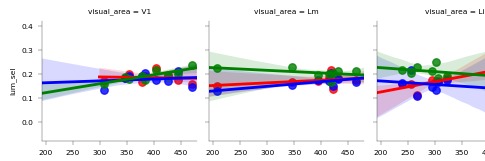

In [611]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=fov_means, 
                  height=2)
fg.map(sns.regplot, 'cortical_distance', 'morph_sel', truncate=False,
      color='r')
fg.map(sns.regplot, 'cortical_distance', 'size_tol', truncate=False,
      color='b')
fg.map(sns.regplot, 'cortical_distance', 'lum_sel', truncate=False,
      color='g')

In [612]:
# Binning params
n_bins=6
use_quartile=False
custom_bins=False
cmap='viridis'
qcolor_list = sns.color_palette(cmap, n_colors=n_bins)
# Bin data
to_quartile='cortical_distance'
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins)
bcorrs, bins_ = cr.bin_column_values(diffdf, to_quartile=to_quartile, 
                                     use_quartile=use_quartile, return_bins=True,
                                     n_bins=n_bins, bins=bins, labels=bin_labels)

In [613]:
# metric = 'morph_sel'
# print(bcorrs.groupby(['binned_%s' % to_quartile])[[to_quartile, metric]]\
#       .mean().to_markdown())

<IPython.core.display.Javascript object>


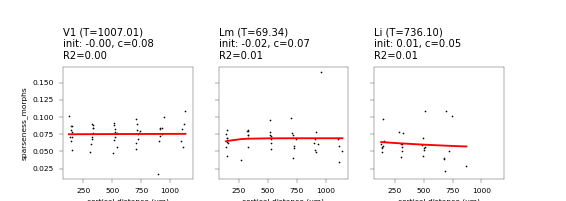

In [614]:
metric = 'sparseness_morphs'
fit_sites=True
min_npairs = 3
n_iter=0
x_var = 'binned_%s' % to_quartile
cnt_grouper = [x_var, 'datakey'] if fit_sites else [x_var]

fig, axn = pl.subplots(1,3, figsize=(7,2.5), sharex=True, sharey=True)
for va, cc0 in bcorrs.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    cnts = cc0.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(cnts[cnts>min_npairs].index.tolist(),
                               cnts[cnts>min_npairs].values))
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in cc0.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    fov_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    
    data = fov_cc.groupby(x_var).median()
    xd = data.sort_values(by=to_quartile)['cortical_distance'].values
    yd = data.sort_values(by=to_quartile)[metric].values
    #ax.plot(xd, yd, lw=0, color='k', marker='.')
    sns.scatterplot(x=to_quartile, y=metric, data=fov_cc, ax=ax,
                    s=2, color='k')
    res_, xvals, yvals = cr.fit_decay_on_binned(fov_cc, use_binned=False,
                                                normalize_x=True, func='halflife',
                                                estimator='median',
                                                metric=metric, #bin_column=bin_column,
                                                to_quartile=to_quartile,
                                                return_inputs=True)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='no fit'
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        ax.plot(xvals, fit_y, color='r')
        label = '%s (T=%.2f)\ninit: %.2f, c=%.2f\nR2=%.2f' \
                                % (va, res_.tau, res_.init, res_.constant, res_.R2)
    #ax.set_ylim([-0.2, 0.6])
    ax.set_title(label, loc='left')
    ax.set_xlabel('cortical distance (um)')
   #ax.set_title(va)
    
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.8, top=0.7)

<IPython.core.display.Javascript object>


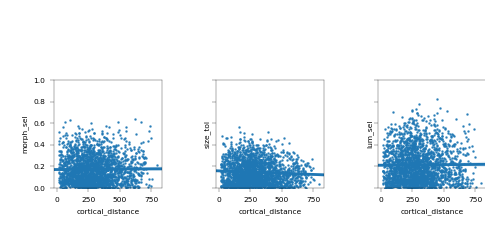

In [615]:
va='Li'
dk='20191105_JC117_fov1'
df_ = diffdf[(diffdf.visual_area==va) & (diffdf.datakey==dk)]

fig, axn = pl.subplots(1,3, figsize=(6, 3), sharex=True, sharey=True)
for ax, metric in zip(axn.flat, ['morph_sel', 'size_tol', 'lum_sel']):
    ax.set_ylim([0, 1])
    #ax.set_aspect('equal')
    sns.regplot(x='cortical_distance', y=metric, data=df_, ax=ax,
               truncate=False, scatter_kws={'s':1})
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.5)

<IPython.core.display.Javascript object>


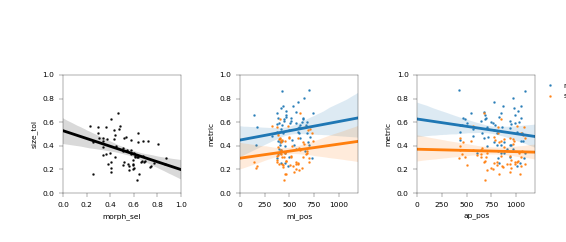

In [616]:
df_ = df0[(df0.visual_area==va) & (df0.datakey==dk)]
fig, axn = pl.subplots(1, 3, figsize=(7, 3), sharex=False, sharey=False)
ax=axn[0]
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
ax.set_aspect('equal')
sns.regplot(x='morph_sel', y='size_tol', ax=ax, data=df_,
           truncate=False, color='k', scatter_kws={'s':1})

for ax, axis in zip(axn.flat[1:], ['ml_pos', 'ap_pos']):
    ax.set_ylim([0,1])
    ax.set_xlim([0, 1200])
    sns.regplot(x=axis, y='morph_sel', ax=ax, data=df_, label='morph_sel',
               truncate=False, scatter_kws={'s':1})
    sns.regplot(x=axis, y='size_tol', ax=ax, data=df_, label='size_tol',
               truncate=False, scatter_kws={'s':1})
    ax.set_ylabel('metric')
    #ax.set_aspect(0.1)
    #force_aspect(ax,aspect=1)
    ax.set_box_aspect(1)
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.5)

In [617]:
min_ncells_plots = 50

curr_ds = cnts[ (cnts.n_cells>=min_ncells)]


AttributeError: 'Series' object has no attribute 'n_cells'

In [618]:
curr_ds['visual_area'].value_counts().max()

10

<IPython.core.display.Javascript object>


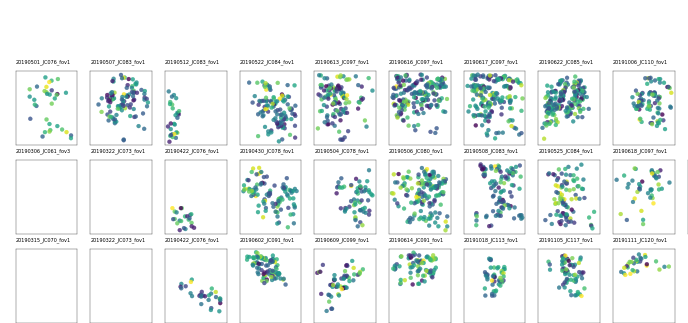

In [619]:
metric = 'morph_sel'
cmap='viridis'
max_nfovs = curr_ds['visual_area'].value_counts().max()
fig, axn = pl.subplots(3, max_nfovs, sharex=True, sharey=True, figsize=(8.5,4))

for va, curr_ in curr_ds.groupby('visual_area'):
    vi = visual_areas.index(va)
    for ai, (va, dk, nc, _) in enumerate(curr_.values):
        ax=axn[vi, ai]
        ax.set_title(dk, fontsize=4, loc='left')
        df_ = df0[(df0.visual_area==va) & (df0.datakey==dk)]

        sns.scatterplot(x='ml_pos', y='ap_pos', data=df_, ax=ax,
                        hue=metric, palette=cmap, s=10, 
                        edgecolor=None, alpha=0.8, legend=False)
        ax.set_aspect('equal')
        #ax.legend_.remove()
        ax.tick_params(which='both', axis='both', size=0)
        ax.set_xticks([])
        ax.set_yticks([])
    for ax in axn[vi, ai+1:].flat:
        ax.axis('off')
        
pl.subplots_adjust(left=0.02, right=0.98, bottom=0.1, top=0.8)

<IPython.core.display.Javascript object>


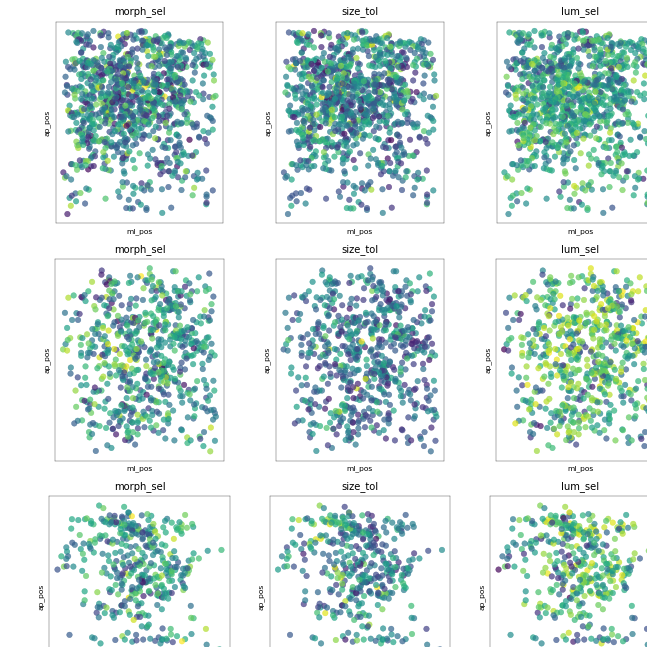

In [636]:
va = 'Lm'
dk = '20190617_JC097_fov1'

# df_ = df0[(df0.visual_area==va) & (df0.datakey==dk)]
df_ = df0[(df0.visual_area==va)]

metric_list = ['morph_sel', 'size_tol', 'lum_sel']
fig, axn = pl.subplots(3,len(metric_list), figsize=(8,8))

for va, df_ in df0.groupby('visual_area'):
    vi = visual_areas.index(va)
    for ai, metric in enumerate(metric_list):
        ax=axn[vi, ai]
        sns.scatterplot(x='ml_pos', y='ap_pos', data=df_, ax=ax,
                        hue=metric, palette=cmap, s=20, 
                        edgecolor=None, alpha=0.7, legend=False,
                        vmin=0, vmax=1)
        ax.set_aspect('equal')
        #ax.legend_.remove()
        ax.tick_params(which='both', axis='both', size=0)
        ax.set_title(metric)
        ax.set_xticks([])
        ax.set_yticks([])
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.3, top=0.8, wspace=0.2, hspace=0.4)
pl.tight_layout()